In [118]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable

In [119]:
batch_size = 5
number_of_labels = 7
classes = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')

transform = transforms.Compose([
     transforms.ToTensor()])

train_dataset = datasets.ImageFolder('expression_faces_dataset/images/train', transform=transform)
validation_dataset = datasets.ImageFolder('expression_faces_dataset/images/validation', transform=transform)

train_loaded = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loaded = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

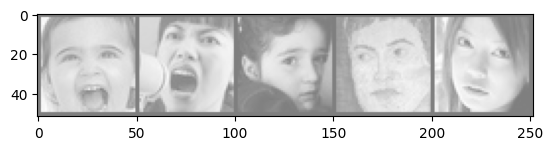

happy angry fear  neutral neutral


In [120]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loaded)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Using CNN (Class of Neural Network) with the following 14 layers:

###### Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> MaxPool -> Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> Linear

In [121]:
class ConvolutionNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionNeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*18*18, 7)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*18*18)
        output = self.fc1(output)

        return output



In [122]:
# Instantiate a neural network model 
model = ConvolutionNeuralNetwork()

In [123]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [124]:
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in validation_loaded:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loaded, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [125]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(validation_loaded))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [126]:
# Let's build our model
train(5)
print('Finished Training')

The model will be running on cpu device
[1,  1000] loss: 1.914
[1,  2000] loss: 1.609
[1,  3000] loss: 1.507
[1,  4000] loss: 1.458
[1,  5000] loss: 1.426
For epoch 1 the test accuracy over the whole test set is 48 %
[2,  1000] loss: 1.352
[2,  2000] loss: 1.331
[2,  3000] loss: 1.334
[2,  4000] loss: 1.289
[2,  5000] loss: 1.255
For epoch 2 the test accuracy over the whole test set is 52 %
[3,  1000] loss: 1.171
[3,  2000] loss: 1.196
[3,  3000] loss: 1.199
[3,  4000] loss: 1.184
[3,  5000] loss: 1.186
For epoch 3 the test accuracy over the whole test set is 53 %
[4,  1000] loss: 1.067
[4,  2000] loss: 1.063
[4,  3000] loss: 1.085
[4,  4000] loss: 1.109
[4,  5000] loss: 1.118
For epoch 4 the test accuracy over the whole test set is 52 %
[5,  1000] loss: 0.963
[5,  2000] loss: 0.984
[5,  3000] loss: 1.016
[5,  4000] loss: 1.020
[5,  5000] loss: 1.046
For epoch 5 the test accuracy over the whole test set is 53 %
Finished Training
